<a href="https://colab.research.google.com/github/J-oyin/Dr.-Jimoh-Analysis/blob/main/Norepinephrine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway, shapiro, levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
df = pd.read_excel("/content/Dr.J_Norepinephrine.xlsx")

df.head()


,S/N,Group,Norepinephrine_level,Subject
0,1,Healthy,57.269,RC1
1,2,Healthy,46.138,RC2
2,3,Healthy,54.814,RC3
3,4,Healthy,23.202,RC4
4,5,Healthy,35.520,RC5


In [3]:
print(df['Group'].unique())
print(df['Group'].value_counts())


['Healthy' 'Resilient' 'S/DW' 'S/Esc' 'S/LASA' 'S/HASA']
Group
Healthy      5
Resilient    5
S/DW         5
S/Esc        5
S/LASA       5
S/HASA       5
Name: count, dtype: int64


In [4]:
for grp, sub in df.groupby('Group'):
    stat, p = shapiro(sub['Norepinephrine_level'])
    print(f"{grp}: Shapiro p = {p:.4f}")


Healthy: Shapiro p = 0.6055
Resilient: Shapiro p = 0.0328
S/DW: Shapiro p = 0.3160
S/Esc: Shapiro p = 0.5915
S/HASA: Shapiro p = 0.7112
S/LASA: Shapiro p = 0.1778


In [5]:
groups = [sub['Norepinephrine_level'].values for _, sub in df.groupby('Group')]
stat, p = levene(*groups)
print(f"Levene test p = {p:.4f}")


Levene test p = 0.1498


In [6]:
from scipy.stats import kruskal

groups = [sub['Norepinephrine_level'].values for _, sub in df.groupby('Group')]


In [7]:
H, p = kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4e}")


Kruskal–Wallis H = 16.979, p = 4.5400e-03


In [8]:
pip install scikit-posthocs


In [9]:
import scikit_posthocs as sp

dunn = sp.posthoc_dunn(
    df,
    val_col='Norepinephrine_level',
    group_col='Group',
    p_adjust='fdr_bh'
)

print(dunn)


            Healthy  Resilient      S/DW     S/Esc    S/HASA    S/LASA
Healthy    1.000000   0.132439  0.787500  0.652215  0.013251  0.221156
Resilient  0.132439   1.000000  0.084278  0.250893  0.397808  0.699902
S/DW       0.787500   0.084278  1.000000  0.497907  0.010241  0.167009
S/Esc      0.652215   0.250893  0.497907  1.000000  0.053582  0.440410
S/HASA     0.013251   0.397808  0.010241  0.053582  1.000000  0.221156
S/LASA     0.221156   0.699902  0.167009  0.440410  0.221156  1.000000


/tmp/ipython-input-3188482892.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Group', y='Norepinephrine_level', palette='Set2',)


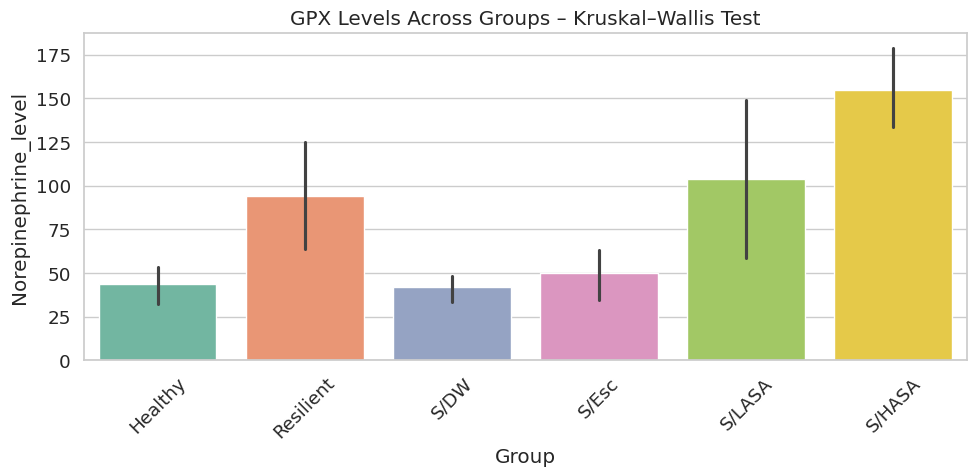

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.barplot(data=df, x='Group', y='Norepinephrine_level', palette='Set2',)
#sns.swarmplot(data=df, x='Group', y='Norepinephrine_level', color='black', size=3)

plt.title("GPX Levels Across Groups – Kruskal–Wallis Test")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

summary_plot = (
    df.groupby('Group')['Norepinephrine_level']
      .agg(mean='mean',
           sem=lambda x: x.std(ddof=1)/np.sqrt(len(x)))
      .reset_index()
)


In [12]:
# Convert Dunn matrix to long format
sig_pairs = []
for g1 in dunn.index:
    for g2 in dunn.columns:
        if g1 != g2:
            p = dunn.loc[g1, g2]
            if p < 0.05:    # Significant
                sig_pairs.append((g1, g2, p))

print("\nSignificant comparisons:", sig_pairs)



Significant comparisons: [('Healthy', 'S/HASA', np.float64(0.013250770277935356)), ('S/DW', 'S/HASA', np.float64(0.010240662336424105)), ('S/HASA', 'Healthy', np.float64(0.013250770277935356)), ('S/HASA', 'S/DW', np.float64(0.010240662336424105))]


In [13]:
def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'


In [14]:
reference_groups = ["Healthy", "Resilient"]

filtered_pairs = [
    (g1, g2, p) for (g1, g2, p) in sig_pairs
    if g1 in reference_groups or g2 in reference_groups
]


/tmp/ipython-input-2846841340.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


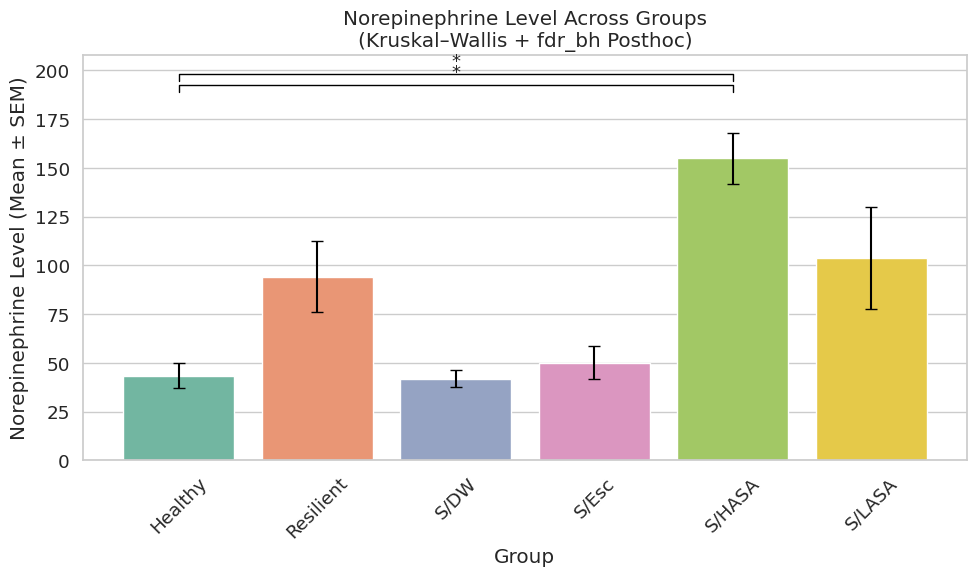

In [15]:
plt.figure(figsize=(10,6))
sns.set(style="whitegrid", font_scale=1.2)

ax = sns.barplot(
    data=summary_plot,
    x='Group',
    y='mean',
    errorbar=None,
    palette='Set2'
)

# Add SEM error bars
for i, row in summary_plot.iterrows():
    ax.errorbar(i, row['mean'], yerr=row['sem'], fmt='none',
                ecolor='black', capsize=4)

    # Add stars for Dunn-significant pairs
y_max = summary_plot['mean'].max() + summary_plot['sem'].max() + 0.05*summary_plot['mean'].max()
height_step = 0.03 * y_max
current_height = y_max
bump = 0.02 * y_max
for (g1, g2, p) in filtered_pairs:
    x1 = summary_plot.index[summary_plot['Group'] == g1][0]
    x2 = summary_plot.index[summary_plot['Group'] == g2][0]

    stars = p_to_stars(p)

    # Draw connecting bracket
    ax.plot([x1, x1, x2, x2],
        [current_height, current_height + bump,
         current_height + bump, current_height],
        c='black', lw=1)

    # Add stars
    ax.text((x1+x2)/2,
            current_height + 0.03*y_max,
            stars,
            ha='center', va='bottom',
            fontsize=13)

    current_height += height_step  # Stack next annotation above

plt.ylabel("Norepinephrine Level (Mean ± SEM)")
plt.title("Norepinephrine Level Across Groups\n(Kruskal–Wallis + fdr_bh Posthoc)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp

# ───────────────────────────────
# 1. SUMMARY STATISTICS
# ───────────────────────────────
summary = (
    df.groupby('Group')['Norepinephrine_level']
      .agg(
          N='count',
          Median='median',
          Q1=lambda x: np.percentile(x, 25),
          Q3=lambda x: np.percentile(x, 75),
          Mean='mean',
          SD='std'
      )
      .reset_index()
)

summary['IQR'] = summary['Q3'] - summary['Q1']

print("\n=== SUMMARY TABLE (PER GROUP) ===")
print(summary)


# ───────────────────────────────
# 2. KRUSKAL–WALLIS
# ───────────────────────────────
group_arrays = [vals['Norepinephrine_level'].values for _, vals in df.groupby('Group')]

H, p_kw = kruskal(*group_arrays)

kw_table = pd.DataFrame({
    'H_statistic': [H],
    'p_value': [p_kw]
})

print("\n=== KRUSKAL–WALLIS RESULT ===")
print(kw_table)


# ───────────────────────────────
# 3. DUNN POSTHOC TEST (Holm corrected)
# ───────────────────────────────
dunn = sp.posthoc_dunn(df, val_col='Norepinephrine_level', group_col='Group', p_adjust='holm')

print("\n=== DUNN POSTHOC (fdr_bh-corrected) ===")
print(dunn)


# ───────────────────────────────
# 4. MANUSCRIPT-READY TABLE COMBINED
# ───────────────────────────────
manuscript_table = {
    "Summary": summary,
    "Kruskal_Wallis": kw_table,
    "Dunn_Posthoc": dunn
}

print("\n\n==== MANUSCRIPT READY TABLES GENERATED ====")



=== SUMMARY TABLE (PER GROUP) ===
       Group  N   Median       Q1       Q3      Mean         SD      IQR
0    Healthy  5   46.138   35.520   54.814   43.3886  14.143710   19.294
1  Resilient  5   70.049   63.279  137.749   94.1086  40.859239   74.470
2       S/DW  5   45.169   40.654   45.651   41.6966   9.740821    4.997
3      S/Esc  5   51.916   46.632   61.882   49.9312  18.899518   15.250
4     S/HASA  5  145.401  145.401  176.925  154.8466  29.240746   31.524
5     S/LASA  5  128.895   45.169  145.401  103.7818  58.511937  100.232

=== KRUSKAL–WALLIS RESULT ===
   H_statistic  p_value
0    16.978886  0.00454

=== DUNN POSTHOC (fdr_bh-corrected) ===
            Healthy  Resilient      S/DW     S/Esc    S/HASA    S/LASA
Healthy    1.000000   0.485609  1.000000  1.000000  0.024735  1.000000
Resilient  0.485609   1.000000  0.269690  1.000000  1.000000  1.000000
S/DW       1.000000   0.269690  1.000000  1.000000  0.010241  0.668035
S/Esc      1.000000   1.000000  1.000000  1.000000

In [17]:
with pd.ExcelWriter("Norepinephrine_KW_Analysis.xlsx") as writer:
    summary.to_excel(writer, sheet_name="Summary", index=False)
    kw_table.to_excel(writer, sheet_name="Kruskal", index=False)
    dunn.to_excel(writer, sheet_name="Dunn_Posthoc")


In [18]:
groups_to_compare = ["Healthy", "Resilient"]

# Generate contrasts manually
pairs_of_interest = [
    ("Healthy", g) for g in summary_plot["Group"] if g != "Healthy"
] + [
    ("Resilient", g) for g in summary_plot["Group"] if g != "Resilient"
]


In [19]:
import scikit_posthocs as sp

# Produce posthoc matrix (p-values for all)
p_matrix = sp.posthoc_dunn(df, val_col='Norepinephrine_level', group_col='Group', p_adjust='fdr_bh')

# Keep only the contrasts of interest
filtered_pvals = [
    (g1, g2, p_matrix.loc[g1, g2])
    for (g1, g2) in pairs_of_interest
]

/tmp/ipython-input-3479435334.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=summary_plot, x='Group', y='mean', palette='viridis', errorbar=None)


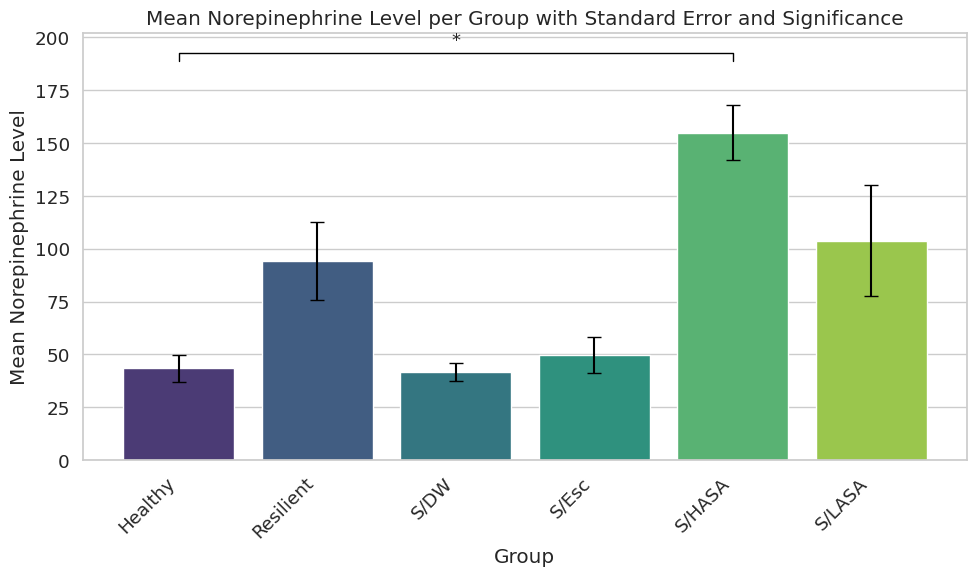

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)

ax = sns.barplot(data=summary_plot, x='Group', y='mean', palette='viridis', errorbar=None)

# Add SEM error bars
for i, row in summary_plot.iterrows():
    ax.errorbar(i, row['mean'], yerr=row['sem'], fmt='none', ecolor='black', capsize=5)

# Add stars for Dunn-significant pairs
y_max = summary_plot['mean'].max() + summary_plot['sem'].max() + 0.05 * summary_plot['mean'].max()
height_step = 0.03 * y_max
current_height = y_max
bump = 0.02 * y_max

# Get unique group names to ensure correct indexing
group_names = summary_plot['Group'].tolist()

for (g1, g2, p) in filtered_pvals:
    if p < 0.05: # Only plot significant pairs
        try:
            x1 = group_names.index(g1)
            x2 = group_names.index(g2)

            stars = p_to_stars(p)

            # Draw connecting bracket
            ax.plot([x1, x1, x2, x2],
                    [current_height, current_height + bump,
                     current_height + bump, current_height],
                    c='black', lw=1)

            # Add stars
            ax.text((x1 + x2) / 2,
                    current_height + 0.03 * y_max,
                    stars,
                    ha='center', va='bottom',
                    fontsize=13)

            current_height += height_step  # Stack next annotation above
        except ValueError: # Handle cases where a group might not be in the plot
            continue

plt.title('Mean Norepinephrine Level per Group with Standard Error and Significance')
plt.xlabel('Group')
plt.ylabel('Mean Norepinephrine Level')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd

# Function to convert p-values to stars
def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

# Build summary statistics table
summary_stats = []

for g1, g2, p in filtered_pvals:

    # (optional) compute effect direction using group means
    mean1 = summary_plot.loc[summary_plot['Group'] == g1, 'mean'].values[0]
    mean2 = summary_plot.loc[summary_plot['Group'] == g2, 'mean'].values[0]
    effect_direction = "↑ " + g2 if mean2 > mean1 else "↓ " + g2

    summary_stats.append({
        "Group 1": g1,
        "Group 2": g2,
        "p-value (FDR-BH)": p,
        "Significance": p_to_stars(p),
        "Mean Group 1": mean1,
        "Mean Group 2": mean2,
        "Effect Direction": effect_direction
    })

summary_stats_df = pd.DataFrame(summary_stats)

# Sort results (optional)
summary_stats_df = summary_stats_df.sort_values(by=["Group 1", "p-value (FDR-BH)"])

summary_stats_df


,Group 1,Group 2,p-value (FDR-BH),Significance,Mean Group 1,Mean Group 2,Effect Direction
3,Healthy,S/HASA,0.013251,*,43.3886,154.8466,↑ S/HASA
0,Healthy,Resilient,0.132439,ns,43.3886,94.1086,↑ Resilient
4,Healthy,S/LASA,0.221156,ns,43.3886,103.7818,↑ S/LASA
2,Healthy,S/Esc,0.652215,ns,43.3886,49.9312,↑ S/Esc
1,Healthy,S/DW,0.787500,ns,43.3886,41.6966,↓ S/DW
6,Resilient,S/DW,0.084278,ns,94.1086,41.6966,↓ S/DW
5,Resilient,Healthy,0.132439,ns,94.1086,43.3886,↓ Healthy
7,Resilient,S/Esc,0.250893,ns,94.1086,49.9312,↓ S/Esc
8,Resilient,S/HASA,0.397808,ns,94.1086,154.8466,↑ S/HASA
9,Resilient,S/LASA,0.699902,ns,94.1086,103.7818,↑ S/LASA
